In [1]:
from collections import defaultdict
from attrs import define
import numpy as np
from tqdm import tqdm

In [2]:
def load_data(
    path,
):
    with open(path, "r") as f:
        lines = f.readlines()
        dimension = int(lines[3].split(":")[1])
        capacity = int(lines[5].split(":")[1])
        idx = 7
        graph = [None] * dimension
        while len(lines[idx].strip().split(" ")) == 3:
            node, x, y = lines[idx].strip().split(" ")
            graph[int(node) - 1] = (int(x), int(y))
            idx += 1

        graph = np.array(graph)

        idx += 1
        needs = np.zeros(dimension, dtype=np.int32)
        while len(lines[idx].strip().split(" ")) == 2:
            node, cap = lines[idx].strip().split(" ")
            needs[int(node) - 1] = int(cap)
            idx += 1

    return graph, needs, dimension, capacity
graph, needs, dimension, capacity = load_data("data/E/E-n23-k3.vrp")

In [3]:
def distance(coords):
    return np.linalg.norm(coords, axis=-1)

In [4]:
# Calculate the euclidian distance in n-space of the route r traversing cities c, ending at the path start.
path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])
# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))

def TSP_loop(
    graph,
    path,
    initial_node = 0,
    improvement_threshold=0.001
):
    cities = np.vstack((graph[path], graph[0]))

    route = np.arange(cities.shape[0]) # Make an array of row numbers corresponding to cities.
    improvement_factor = 1 # Initialize the improvement factor.
    best_distance = path_distance(route,cities) # Calculate the distance of the initial path.
    while improvement_factor > improvement_threshold: # If the route is still improving, keep going!
        distance_to_beat = best_distance # Record the distance at the beginning of the loop.
        for swap_first in range(1,len(route)-2): # From each city except the first and last,
            for swap_last in range(swap_first+1,len(route)): # to each of the cities following,
                new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities
                new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                if new_distance < best_distance: # If the path distance is an improvement,
                    route = new_route # make this the accepted best route
                    best_distance = new_distance # and update the distance corresponding to this route.
        improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
    return path[route[route != cities.shape[0] -1]] # When the route is no longer improving substantially, stop searching and return the route.

# route = np.array([1, 2, 3, 4, 22, 31], dtype=np.int32)
# print(calc_path_metric(graph, route))
# route = TSP_loop(graph, np.array([1, 2, 3, 4, 22, 31]), 0.001)
# print(calc_path_metric(graph, route))

# output: 
# 343.1853049674675
# 281.23099883169414

In [42]:
def random_construct_loop(
    graph, 
    needs, 
    nodes_pool, # pool клиентов еще не обслуженных
    capacity,
    initial_node = 0,
):
    assert initial_node not in nodes_pool
    nodes_pool = np.array(nodes_pool)
    np.random.shuffle(nodes_pool)

    current_capacity = 0
    # print(needs.shape[0])
    needs = np.cumsum(needs[nodes_pool]) < capacity
    return TSP_loop(graph, nodes_pool[needs])

In [43]:
def construct_gene(
    graph, 
    needs, 
    capacity,
    initial_node = 0,
    dimension = None,
    construct_loop = random_construct_loop,
): 
    if dimension is None:
        dimension = graph.shape[0]
    nodes_pool = np.arange(1, dimension)
    gene = []
    while nodes_pool.shape[0] != 0:
        gene.append(construct_loop(graph, needs, nodes_pool, capacity, initial_node))
        nodes_pool = nodes_pool[~np.in1d(nodes_pool,gene[-1])]
    return gene

In [21]:
def random_mutation(
    gene, 
    graph, 
    needs, 
    capacity,
    alpha=3,
    initial_node = 0,
    dimension = None,
    construct_loop = random_construct_loop,
):
    fraction = alpha # в контексте данного подхода к мутации - 
    # альфа это часть гена, которая пересоберется заного

    # fully recreate part of gene
    # количество изменяемых генов семплируем из 
    # експоненциального распределения
    # с минимум 2 пермутациями
    p = alpha * np.exp(-alpha * np.arange(len(gene) - 2))
    p = p / p.sum()
    size_recr = np.random.choice(len(gene) - 2, size=1, p=p)[0] + 2

    # size_recr = int(fraction * len(gene))
    # p = np.exp(-np.arange(len(gene) - size_recr))
    # p[0] = 1 - p.sum()
    # size_recr = np.random.choice(np.arange(size_recr, len(gene)), size=1, p=p)
    # print(size_recr, len(gene))
    # size_recr = size_recr if size_recr > 1 else 2

    genes_reassemble = np.random.choice(len(gene), replace=False, size=size_recr)
    nodes_pool = np.hstack([gene[gr] for gr in genes_reassemble])
    gene = [gene[gr] for gr in range(len(gene)) if gr not in genes_reassemble]
    while nodes_pool.shape[0] != 0:
        gene.append(construct_loop(graph, needs, nodes_pool, capacity, initial_node))
        nodes_pool = nodes_pool[~np.in1d(nodes_pool,gene[-1])]
    return gene

In [22]:
def random_crossingover(
    gene1, 
    gene2,
    graph,
    dimension,
    capacity,
    needs,
    initial_node = 0,
    construct_loop = random_construct_loop,
):
    # оба гена вносят равный вклад, и остаток - случайно заполняется
    nodes_pool = np.arange(1, dimension)
    new_gene = []
    idxs = [0, 0]
    merging = 0
    genes = [gene1, gene2]
    while idxs[0] < len(gene1) and idxs[1] < len(gene2):
        if np.in1d(genes[merging][idxs[merging]], nodes_pool).all():
            new_gene.append(genes[merging][idxs[merging]])
            nodes_pool = nodes_pool[~np.in1d(nodes_pool,new_gene[-1])]
            idxs[merging] += 1
            merging = 1 if merging == 0 else 0
        else:
            idxs[merging] += 1
    
    merging = 1 if merging == 0 else 0
    while idxs[merging] < len(genes[merging]):
        if np.in1d(genes[merging][idxs[merging]], nodes_pool).all():
            new_gene.append(genes[merging][idxs[merging]])
            nodes_pool = nodes_pool[~np.in1d(nodes_pool,new_gene[-1])]
        idxs[merging] += 1

    while nodes_pool.shape[0] != 0:
        new_gene.append(construct_loop(graph, needs, nodes_pool, capacity, initial_node))
        nodes_pool = nodes_pool[~np.in1d(nodes_pool, new_gene[-1])]
    return new_gene

In [23]:
gene1 = construct_gene(
    graph, 
    needs, 
    capacity,
)
gene2 = construct_gene(
    graph, 
    needs, 
    capacity,
)

res = random_crossingover(
    gene1, 
    gene2,
    graph,
    dimension,
    capacity,
    needs,
)

res

[array([17, 12]),
 array([3, 5, 4]),
 array([10, 22]),
 array([ 9,  8, 21,  7, 18, 20, 14, 15, 16,  1,  6, 11, 13]),
 array([19,  2])]

In [24]:
def calc_path_metric(
    graph, 
    path_nodes,
    initial_node = 0,
):
    assert initial_node not in path_nodes
    path_distance = distance(graph[path_nodes[0]] - graph[initial_node]) + \
               distance(graph[path_nodes[-1]] - graph[initial_node])
    path_distance += np.sum(
        np.sqrt(
            np.sum(
                np.square(
                    graph[path_nodes[:-1]] - graph[path_nodes[1:]]
                ), axis=1
            )
        )
    )
    return path_distance

def calc_gene_metric(
    graph,
    gene, # array of paths
    initial_node = 0,
):
    gene_metric = 0
    for path in gene:
        gene_metric += calc_path_metric(graph, path, initial_node)
    return gene_metric


In [38]:
def sampling_selection(
    graph,
    population,
    sample_size,
    initial_node = 0,
    temperature = 0.7,
    max_fitness_scale = 30,
): 
    fitness_vector = np.array([calc_gene_metric(graph, gene, initial_node=initial_node) for gene in population])
    fitness_vector_probs = fitness_vector - fitness_vector.min() + 1 # чтобы / 0 не было
    fitness_vector_probs = - fitness_vector_probs / fitness_vector_probs.max() * max_fitness_scale
    # fitness_vector_probs = 1 / fitness_vector_probs
    fitness_vector_probs = np.exp(fitness_vector_probs / temperature)
    fitness_vector_probs = fitness_vector_probs / fitness_vector_probs.sum()
    selection = np.random.choice(fitness_vector.shape[0], size=int((1 - sample_size) * len(population)), p=fitness_vector_probs)
    return [population[sel] for sel in selection], fitness_vector[selection]

def max_selection(
    graph,
    population,
    sample_size,
    initial_node = 0,
    temperature = 0.7,
    max_fitness_scale = 30,
): 
    sample_size = int((1 - sample_size) * len(population))
    fitness_vector = np.array([calc_gene_metric(graph, gene, initial_node=initial_node) for gene in population])
    selection = np.argpartition(fitness_vector, sample_size)[:sample_size]
    return [population[sel] for sel in selection], fitness_vector[selection]

In [47]:
def cross_population_sampling(
    graph,
    population,
    new_population_size,
    fitness_vector,
    dimension,
    capacity,
    needs,
    initial_node = 0,
    temperature = 0.7,
    construct_loop = random_construct_loop,
    cross_function = random_crossingover,
    max_fitness_scale = 30,
):
    fitness_vector_probs = fitness_vector - fitness_vector.min() + 1 # чтобы / 0 не было
    fitness_vector_probs = - fitness_vector_probs / fitness_vector_probs.max() * max_fitness_scale
    # fitness_vector_probs = 1 / fitness_vector_probs
    fitness_vector_probs = np.exp(fitness_vector_probs / temperature)
    fitness_vector_probs = fitness_vector_probs / fitness_vector_probs.sum()
    # print(np.partition(fitness_vector_probs, len(population) - 10)[len(population) - 10:])
    population_income = []
    while len(population_income) < new_population_size - len(population) :
        cross_genes_idx = np.random.choice(len(population), size=2, replace=False, p=fitness_vector_probs)
        population_income.append(cross_function(
            population[cross_genes_idx[0]],
            population[cross_genes_idx[1]],
            graph,
            dimension,
            capacity,
            needs,
            initial_node = 0,
            construct_loop = construct_loop,
        ))
    return population + population_income

def cross_population_random(
    graph,
    population,
    new_population_size,
    fitness_vector,
    dimension,
    capacity,
    needs,
    initial_node = 0,
    temperature = 0.7,
    construct_loop = random_construct_loop,
    cross_function = random_crossingover,
    max_fitness_scale = 30,
):
    best_gene_crossing = (new_population_size - len(population)) // 5
    population_income = []
    best_gene_idx = np.argmin(fitness_vector)
    others_genes = np.arange(len(population))
    others_genes = others_genes[others_genes != best_gene_idx]
    for _ in range(best_gene_crossing):
        cross_genes_idx = np.random.choice(others_genes, replace=False)
        population_income.append(cross_function(
            population[cross_genes_idx],
            population[best_gene_idx],
            graph,
            dimension,
            capacity,
            needs,
            initial_node = 0,
            construct_loop = construct_loop,
        ))
    while len(population_income) < new_population_size - len(population) :
        cross_genes_idx = np.random.choice(len(population), size=2, replace=False)
        population_income.append(cross_function(
            population[cross_genes_idx[0]],
            population[cross_genes_idx[1]],
            graph,
            dimension,
            capacity,
            needs,
            initial_node = 0,
            construct_loop = construct_loop,
        ))
    return population + population_income

In [48]:
def greedy_loop(
    graph, 
    needs, 
    nodes_pool, # pool клиентов еще не обслуженных
    capacity,
    proximity_metric,
    initial_node = 0,
    temperature = 0.5
):
    proximity_metric = proximity_metric[nodes_pool]
    proximity_metric = proximity_metric / proximity_metric.max() * 40
    proximity_metric = np.exp(proximity_metric / temperature)
    proximity_metric = proximity_metric / proximity_metric.sum()
    node_optimize = np.random.choice(nodes_pool, size=1, p=proximity_metric)[0]
    initial_hub = graph[node_optimize]
    distances = distance(graph[nodes_pool] - initial_hub)
    cur_cap = needs[node_optimize]
    path = [node_optimize]
    sorted_dist = np.argsort(distances)
    for node in nodes_pool[sorted_dist]:
        if node != node_optimize:
            if cur_cap + needs[node] < capacity:
                cur_cap += needs[node]
                path.append(node)

    return TSP_loop(graph, np.array(path))

def population_initialization(
    graph, 
    needs,
    pop_size,
    dimension,
    capacity,
    initial_node = 0,
):
    # Можно разумно инициализировать популяцию
    population = []
    client_proximity_metric = distance(graph - graph[initial_node]) * needs
    for _ in range(pop_size):
        nodes_pool = np.arange(1, dimension)
        gene = []
        while nodes_pool.shape[0] != 0:
            gene.append(
                greedy_loop(
                    graph, 
                    needs, 
                    nodes_pool, # pool клиентов еще не обслуженных
                    capacity,
                    client_proximity_metric,
                    initial_node = initial_node,
                )
            )
            nodes_pool = nodes_pool[~np.in1d(nodes_pool,gene[-1])]
        population.append(gene)

    return population

In [49]:
from tqdm import tqdm

def calc_best_solution(
    data_path = "data/B/B-n31-k5.vrp",
    population_size = 100,
    evolution_steps = 100,
    mutation_factor = 3,
    dieback_rate = 0.8,
    temperature = 0.2,
    crossingover = random_crossingover,
    construct_loop = random_construct_loop,
    mutation = random_mutation,
    cross_population = cross_population_random,
    selection = max_selection,
    use_tqdm=False,
):
    graph, needs, dimension, capacity = load_data(data_path)

    # generate population
    population = population_initialization(
        graph, 
        needs,
        population_size,
        dimension,
        capacity,
        initial_node = 0,
    )
    best_solution = (population[0], calc_gene_metric(graph, population[0]))

    pbar = range(evolution_steps)
    if use_tqdm:
        pbar = tqdm(pbar)
    for eval_steps in pbar:
        # mutate
        population = [
            mutation(
            gene, 
            graph, 
            needs, 
            capacity,
            alpha=mutation_factor,
            construct_loop = construct_loop,
        ) for gene in population]
        
        # select
        population, fit = selection(
            graph,
            population,
            sample_size=dieback_rate,
            temperature = temperature,
        )
        if use_tqdm:
            pbar.set_postfix_str(f"best fit: {np.min(fit)}")
        # remember best solution
        if best_solution[1] > fit.min():
            fit_min = np.argmin(fit)
            best_solution = (population[fit_min], fit[fit_min]) 

        # cross over
        population = cross_population(
            graph,
            population,
            population_size,
            fit,
            dimension,
            capacity,
            needs,
            temperature = temperature,
            construct_loop = construct_loop,
            cross_function = crossingover,
        )

    return best_solution

calc_best_solution(
    data_path = "data/A/A-n80-k10.vrp",
    population_size = 300,
    evolution_steps = 100,
    mutation_factor = 3,
    dieback_rate = 0.8,
    temperature = 0.2,
    crossingover = random_crossingover,
    construct_loop = random_construct_loop,
    mutation = random_mutation,
    use_tqdm=True,
)

100%|██████████| 100/100 [02:37<00:00,  1.58s/it, best fit: 2023.8899143302694]


([array([ 9, 54, 72, 64, 41, 25, 47, 26, 65, 69, 56, 55, 15, 33]),
  array([57, 61, 16, 43, 68, 78, 20, 75, 19, 35]),
  array([34, 79, 18, 48, 28, 52, 14, 71]),
  array([73, 38, 66, 67, 53, 36, 42]),
  array([70, 58, 32,  4, 22, 45, 50, 76]),
  array([62, 23, 63, 10,  7]),
  array([40, 21,  1, 13, 49]),
  array([30,  8, 37,  2,  6, 24, 11]),
  array([44, 12, 74, 39, 60, 29]),
  array([ 5, 27, 59, 46, 31, 17,  3, 77, 51])],
 1993.1464887224288)

In [57]:
from datetime import datetime
was = datetime.now()

str((datetime.now() - was).replace(microseconds=0))

AttributeError: 'datetime.timedelta' object has no attribute 'replace'

In [60]:
from pathlib import Path
import time

def dump_solution(solution, score, file_name, time_execution):
    # Route #1: 21 31 19 17 13 7 26
    # Route #2: 12 1 16 30
    # Route #3: 27 24
    # Route #4: 29 18 8 9 22 15 10 25 5 20
    # Route #5: 14 28 11 4 23 3 2 6
    # Cost 784

    file_lines = []
    for idx, sol in enumerate(solution):
        file_lines.append(f'Route #{idx + 1}: {" ".join(map(str, sol))}\n')
    file_lines.append(f"Cost {int(score)}")
    with open(file_name, "w") as f:
        f.writelines(file_lines)
    with open(file_name.with_suffix(".time"), "w") as f:
        f.write(f"{time_execution}")

pbar = tqdm(Path("data/").rglob("*.vrp"), total = len(list(Path("data/").rglob("*.vrp"))))
for file_vrp in pbar:
    pbar.set_postfix_str(str(file_vrp))
    # if not file_vrp.with_suffix(".msol").exists():
    try:
        # Возможно формат некоторых E файлов не подойдет для парсинга
        start = time.time()
        solution, score = calc_best_solution(
            data_path = str(file_vrp),
            population_size = 300,
            evolution_steps = 100,
            mutation_factor = 3,
            dieback_rate = 0.8,
            temperature = 0.2,
            crossingover = random_crossingover,
            construct_loop = random_construct_loop,
            mutation = random_mutation,
        )
        dump_solution(solution, score, file_vrp.with_suffix(".msol"), time.time() - start)
    except:
        continue

100%|██████████| 63/63 [2:03:48<00:00, 117.91s/it, data/E/E-n23-k3.vrp]  


### Анализ

#### Посчитаем разницу времени исполнения

In [68]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm import tqdm

def load_results(results_file):
    with open(results_file, "r") as f:
        lines = f.readlines()
        cost = int(lines[-1].split(" ")[1])
        # solution = [np.array(list(map(int, ln.split(": ")[1].split(" ")))) for ln in lines[:-1]]
    return cost

In [80]:
pbar = tqdm(Path("data/").rglob("*.msol"), total = len(list(Path("data/").rglob("*.msol"))))
agg_results = []
index = []
for file_vrp in pbar:
    timing = float(open(file_vrp.with_suffix(".time"), "r").read())
    agg_results.append({
        "our_sol": load_results(file_vrp),
        "sol": load_results(file_vrp.with_suffix(".sol")),
        "seconds": timing,
    })
    index.append(file_vrp.stem)

agg_results = pd.DataFrame(agg_results, index=index)
agg_results.head()

100%|██████████| 61/61 [00:00<00:00, 13640.38it/s]


,our_sol,sol,seconds
B-n45-k5,866,751,166.575440
B-n44-k7,961,909,75.965779
B-n45-k6,800,678,88.806664
B-n43-k6,859,742,106.777072
B-n35-k5,1058,955,104.834689


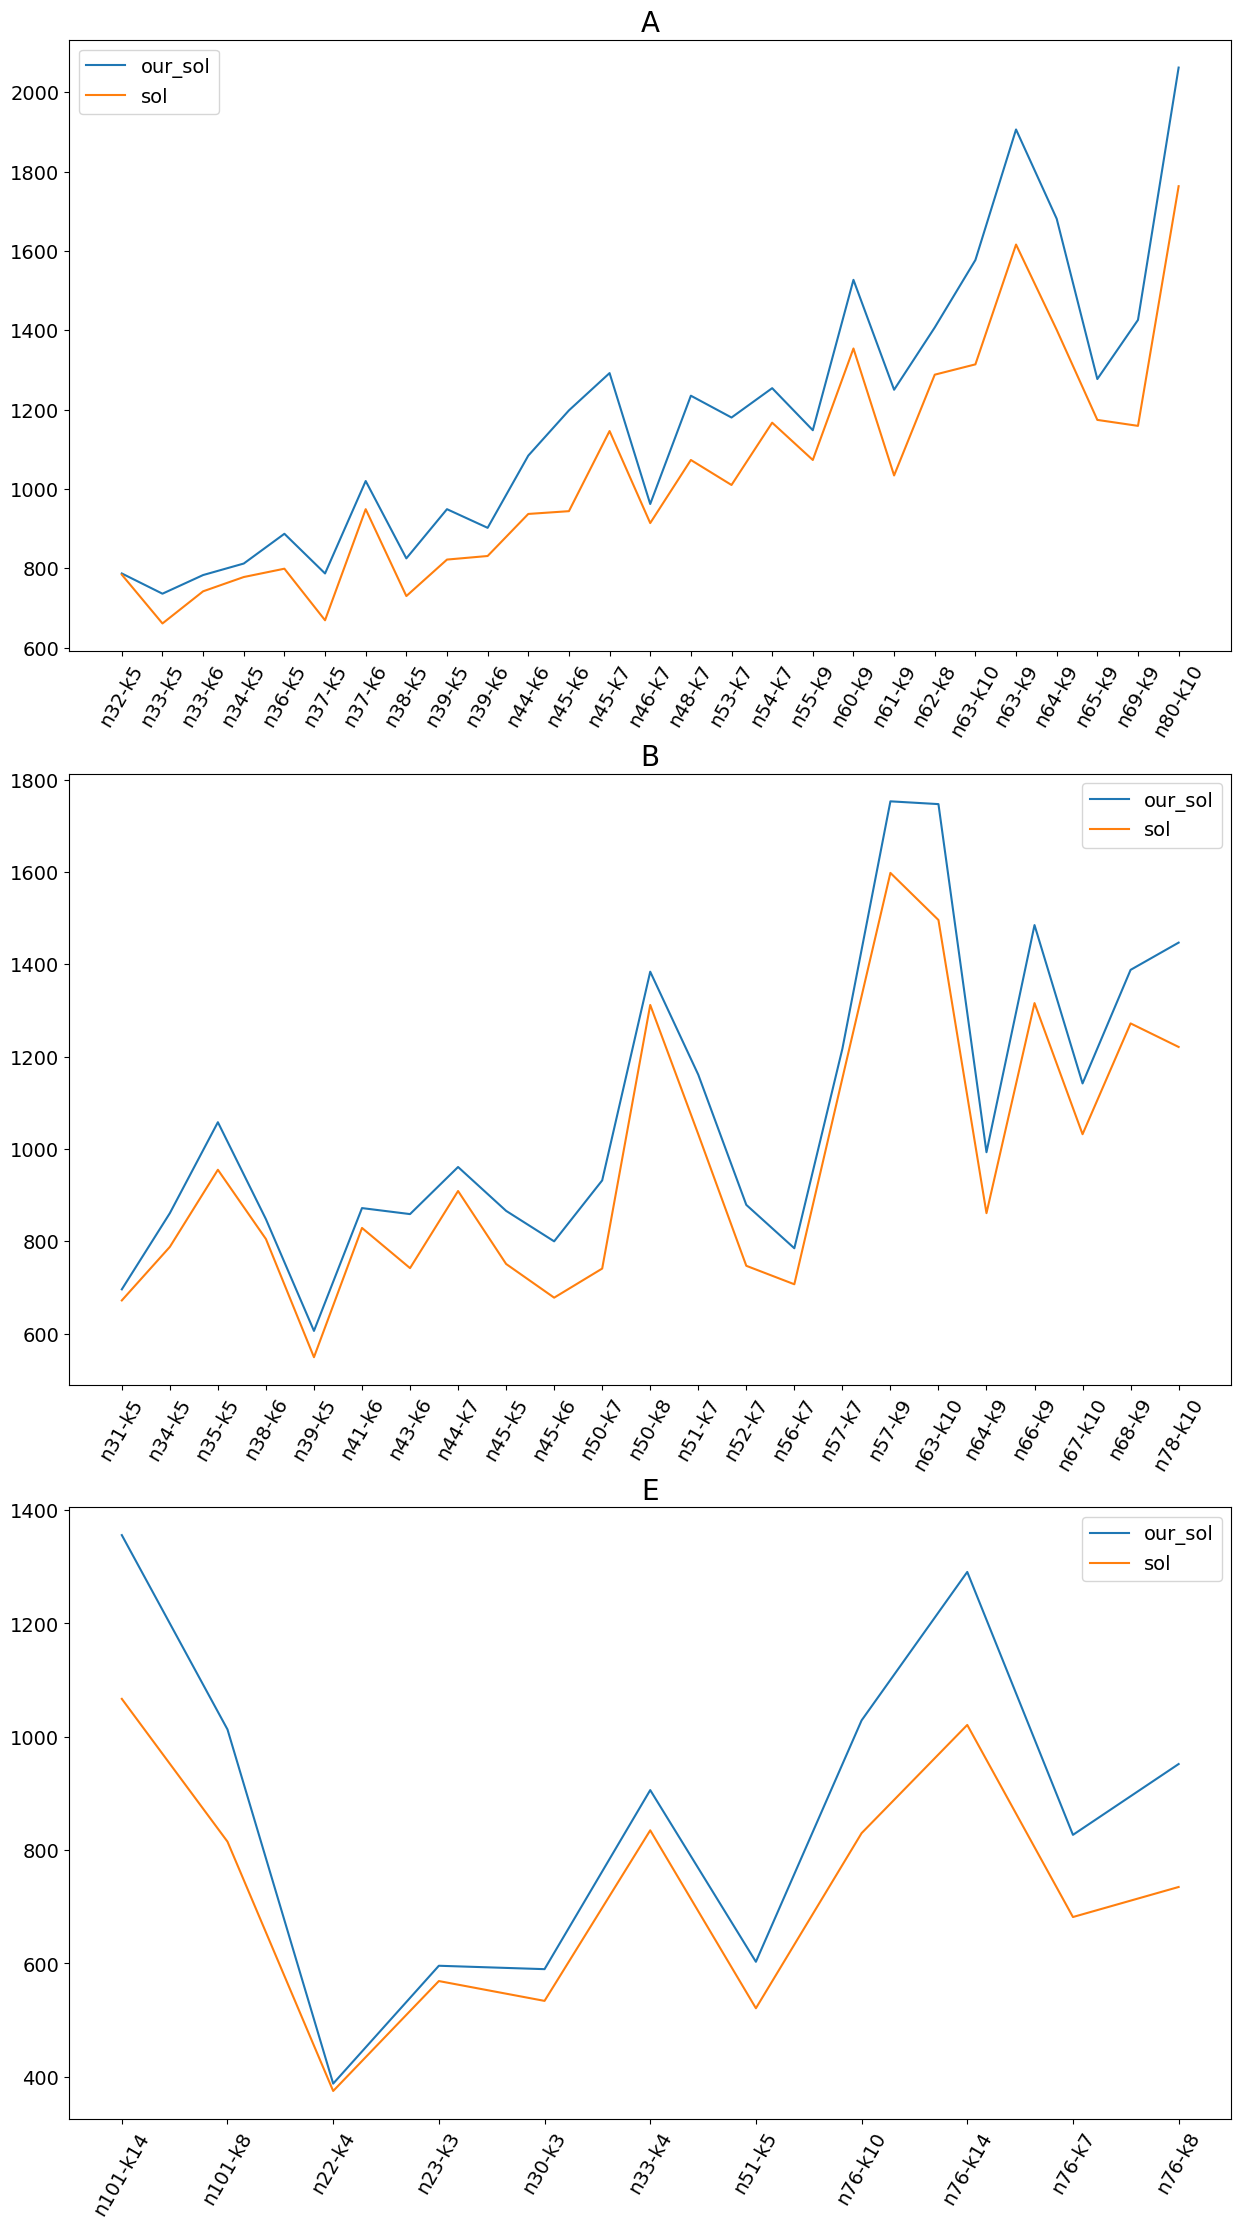

In [90]:
fig, ax = plt.subplots(3, 1, figsize=(15, 27))

for idx, task_type in enumerate(["A", "B", "E"]):
    plot_res = agg_results[agg_results.index.str.contains(task_type)]
    plot_res.index = plot_res.index.str.split("-").str[1:].str.join("-")
    plot_res = plot_res.sort_index()
    # print(plot_res)
    ax[idx].plot(np.arange(len(plot_res)), plot_res["our_sol"], label="our_sol")
    ax[idx].plot(np.arange(len(plot_res)), plot_res["sol"], label="sol")
    ax[idx].set_xticks(np.arange(len(plot_res)), plot_res.index, rotation=60, fontsize=14)
    ax[idx].set_title(task_type, size=20)
    ax[idx].tick_params(axis="y", labelsize=14)
    ax[idx].legend(fontsize=14)

fig.savefig("result.png")

In [82]:
diff = np.abs(agg_results["our_sol"] - agg_results["sol"]) / agg_results["sol"]

for letter in ["A", "B", "E"]:
    print(letter)
    print(diff[diff.index.str.startswith(letter)].describe())

A
count    27.000000
mean      0.130130
std       0.063668
min       0.003827
25%       0.080127
50%       0.127770
75%       0.172990
max       0.269068
dtype: float64
B
count    23.000000
mean      0.117515
std       0.055268
min       0.035714
25%       0.074200
50%       0.107853
75%       0.155496
max       0.257760
dtype: float64
E
count    11.000000
mean      0.177751
std       0.095432
min       0.034667
25%       0.094949
50%       0.212610
75%       0.253696
max       0.295238
dtype: float64


In [83]:
for letter in ["A", "B", "E"]:
    print(letter)
    print(agg_results.loc[diff.index.str.startswith(letter), "seconds"].describe())

A
count     27.000000
mean      95.932288
std       26.023742
min       50.198760
25%       78.172077
50%       90.750459
75%      114.456568
max      161.780094
Name: seconds, dtype: float64
B
count     23.000000
mean     105.739141
std       26.348127
min       72.571496
25%       83.194538
50%      104.308639
75%      127.082588
max      166.575440
Name: seconds, dtype: float64
E
count     11.000000
mean     218.732884
std      156.849171
min       34.191218
25%      108.263979
50%      200.125938
75%      284.570728
max      569.490948
Name: seconds, dtype: float64
